In [83]:
!pip install tensorflow

In [84]:
!pip install librosa

In [103]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
%matplotlib inline
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [86]:
# Define the path to the dataset
data_name = "C:\\Users\\DELL\\Downloads\\toronto\\Toronto Dataset\\TESS Toronto emotional speech set data"

In [87]:

features = []
labels = []

# Iterate through each folder in the dataset
for folder in os.listdir(data_name):
    folder_path = os.path.join(data_name, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract emotion label from folder name
        
        # Iterate through each file in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            
            if filename.endswith('.wav'):
                audio, sr = librosa.load(file_path, duration=3)  # Load audio
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Extract MFCC
                mfcc_mean = np.mean(mfcc, axis=1)  # Compute mean across time
                
                # Append features and labels to their respective lists
                features.append(mfcc_mean)
                labels.append(emotion_label)

#aI Convert lists to NumPy arrays after processing all files
features = np.array(features) 
labels = np.array(labels)  

# Print the shapes to verify
print("Extracted features shape:", features.shape)  # Expected: (n_samples, 13)
print("Labels shape:", labels.shape) 

Extracted features shape: (2800, 13)
Labels shape: (2800,)


In [88]:
label_encoder = LabelEncoder()
encode_label= label_encoder.fit_transform(labels)

In [89]:
# Define emotions and number of samples per emotion
emotions = ['angry', 'disgust','fear','happy', 'neutral','sad']
num_samples_per_emotion = 3
selected_samples = []

In [90]:

 # Load and select audio samples for emotion in emotions:
emotion_dir = os.path.join(data_name,f'OAF_{emotion}')
audio_files = os.listdir(emotion_dir)
    # Select random files without replacement
selected_files = np.random.choice(audio_files,size = num_samples_per_emotion,replace = False)
    # Load audio files and add them to the selected_samples list
for file_name in selected_files:
        file_path = os.path.join(emotion_dir,file_name)
        audio, sr = librosa.load(file_path, duration = 3)
        selected_samples.append((audio,sr,emotion))

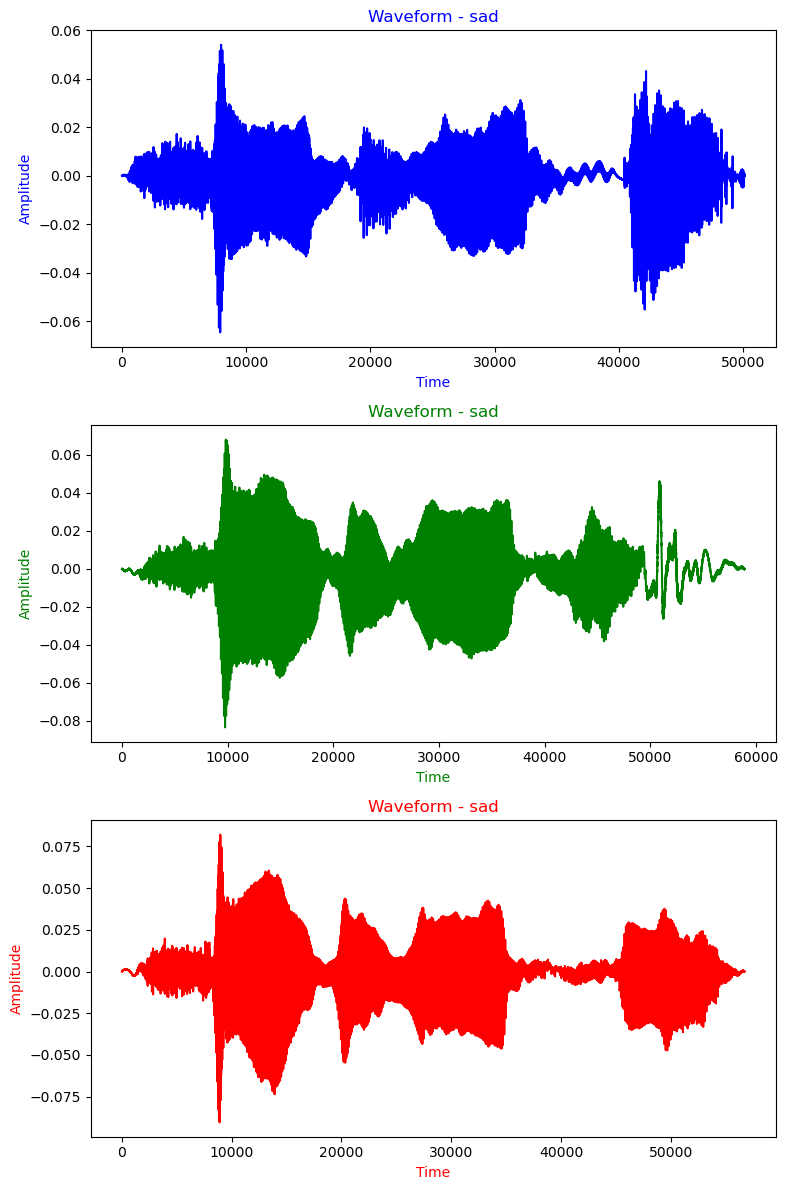

In [91]:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']

# Plotting the waveforms with unique colors
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for k, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, k + 1)
    plt.plot(audio, color=colors[k % len(colors)])  
    plt.title(f'Waveform - {emotion}', color=colors[k % len(colors)]) 
    plt.xlabel('Time', color=colors[k % len(colors)])  
    plt.ylabel('Amplitude', color=colors[k % len(colors)]

plt.tight_layout()
plt.show()

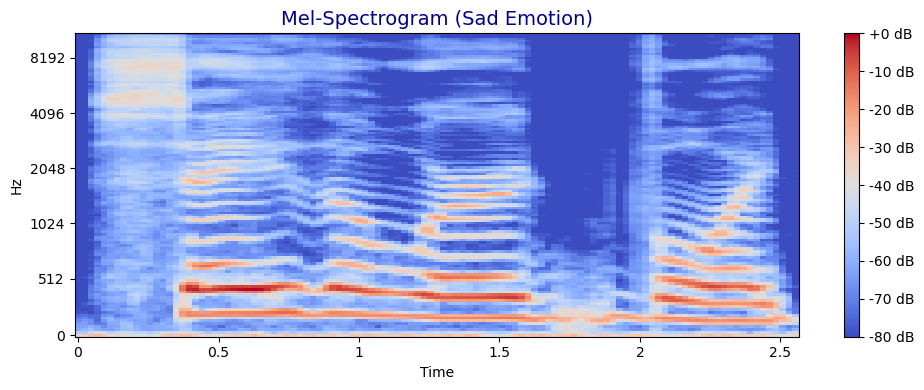

In [92]:
# Generate the mel-spectrogram from the audio signal
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
# change the spectrogram power to decibel (dB) scale for better visualization
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
# Create a figure for the spectrogram with a custom size
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
# i add a color bar to show the decibel scale
plt.colorbar(format='%+2.0f dB')
# I set the title with a clear and descriptive label
plt.title('Mel-Spectrogram (Sad Emotion)', fontsize=14, color='darkblue')
# TO ensure everything fits within the layout
plt.tight_layout()
Audio(file_path)

In [95]:
# Define a fixed length for all audio samples
max_len = 11200 # Set this to your desired fixed length

def pad_or_truncate(data, max_len):
    if len(data) < max_len:
        return np.pad(data, (0, max_len - len(data)), mode='constant')
    else:
        return data[:max_len]

# Initialize lists for storing augmented features and labels
augmented_features = []
augmented_labels = []

# Loop through each feature and label
for feature, label in zip(features, labels):
    feature = pad_or_truncate(feature, max_len)
    
    # Append the original feature and label
    augmented_features.append(feature)
    augmented_labels.append(label)
    
    # Add noise to the original feature
    noise = np.random.randn(len(feature)).astype(np.float32)  
    augmented_features.append(pad_or_truncate(feature + 0.005 * noise, max_len))
    augmented_labels.append(label)
    
    # Apply time stretching (speed change)
    stretched_feature = librosa.effects.time_stretch(feature, rate=1.2)
    augmented_features.append(pad_or_truncate(stretched_feature, max_len))
    augmented_labels.append(label)
    
    # Apply pitch shift (additional augmentation)
    pitched_feature = librosa.effects.pitch_shift(feature, sr=sr, n_steps=0.7) 
    augmented_features.append(pad_or_truncate(pitched_feature, max_len))
    augmented_labels.append(label)

# Convert lists to numpy arrays
augmented_features = np.array(augmented_features)
augmented_labels = np.array(augmented_labels)

# Print the number of original and augmented samples
print('Original samples:', len(features))
print('Augmented samples:', len(augmented_features))

Original samples: 2800
Augmented samples: 11200


In [98]:
# Initialize a list to store preprocessed audio data
preprocessed_data = []
# List all files in the specified data directory
file_list = os.listdir(data_name)
# Iterate through each file in the directory
for filename in file_list:
    file_path = os.path.join(data_name, filename) 
    # Skip files that do not end with .wav
    if not filename.endswith('.wav'):
        continue
    # Load the audio file
    waveform, sr = librosa.load(file_path, sr=None, dtype=np.float32) 
# Resample the waveform if the sample rate is not 22050 Hz
    if sr != 22050:
        waveform = librosa.resample(waveform, sr, 22050) 
        sr = 22050  

In [99]:
# Mapping emotions to integer labels
emotion_to_label = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5
}

# Encode labels using the mapping
encoded_labels = np.array([emotion_to_label.get(label, -1) for label in labels])  # Changed 'labels' to 'label'
valid_indices = np.where(encoded_labels != 1)[0]
filtered_features = features[valid_indices]
filtered_labels = encoded_labels[valid_indices]
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_features, filtered_labels, test_size=0.2, random_state=42)
# Reshape the training and testing features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))
# One-hot encode the labels
num_classes = len(emotion_to_label)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [101]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1920, 13, 1)
y_train shape: (1920, 6)
X_test shape: (480, 13, 1)
y_test shape: (480, 6)


In [105]:
# Initialize the model
model = Sequential()

# Add convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1, 1), padding='same'))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 13, 1, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           2,502 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,822 (11.02 KB)

 Trainable params: 2,822 (11.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))
loss,accuracy = model.evaluate(X_test, y_test)
print('Test loss' loss)
print('Test accuracy' accuracy)

In [107]:
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2956 - loss: 8.0622 - val_accuracy: 0.4229 - val_loss: 1.4010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4582 - loss: 1.3023 - val_accuracy: 0.6271 - val_loss: 0.9290
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6725 - loss: 0.8558 - val_accuracy: 0.7188 - val_loss: 0.7476
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7684 - loss: 0.6924 - val_accuracy: 0.8021 - val_loss: 0.6253
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7956 - loss: 0.5921 - val_accuracy: 0.8229 - val_loss: 0.5598
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8145 - loss: 0.5382 - val_accuracy: 0.8146 - val_loss: 0.5140
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8106 - loss: 0.5133 - val_accuracy: 0.8354 - val_loss: 0.4576
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8496 - loss: 0.4319 - val_accuracy: 0.8479 - val_loss

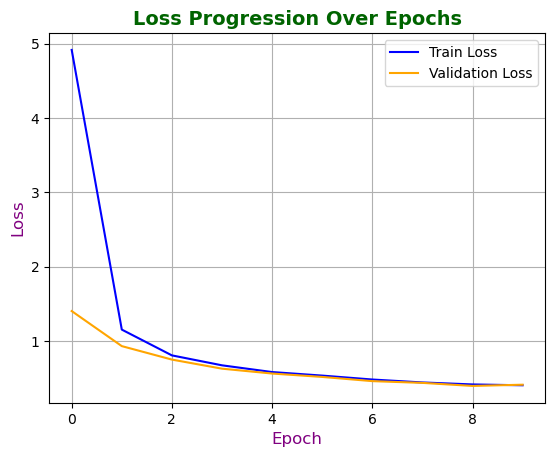

In [108]:
plt.plot(history.history['loss'], color='blue', label='Train Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss Progression Over Epochs', fontsize=14, fontweight='bold', color='darkgreen')
plt.xlabel('Epoch', fontsize=12, color='purple')
plt.ylabel('Loss', fontsize=12, color='purple')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis = 1)
y_true_labels - np.argmax(y_test, axis=1)
cm = confusion_max(y_true_labels, y_pred_labels)
class_names = ['angry','disgust','fear','happy','neutral','sad']
report = classification_report((y_true_labels, y_predlabels, target_names = class_names,yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

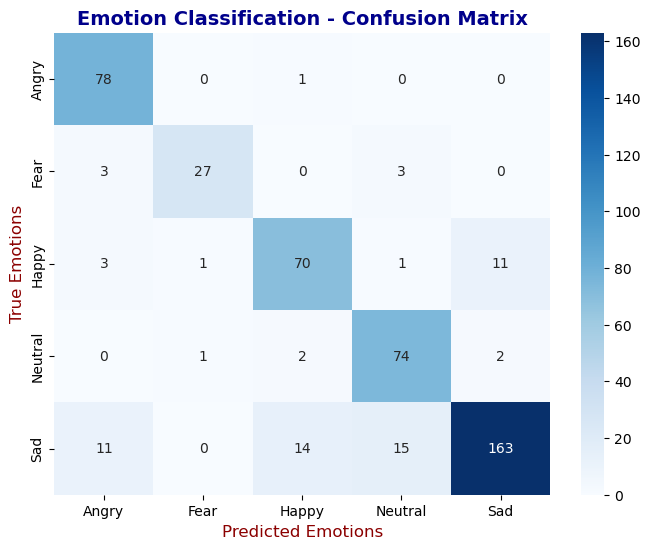

              precision    recall  f1-score   support

       Angry       0.82      0.99      0.90        79
        Fear       0.93      0.82      0.87        33
       Happy       0.80      0.81      0.81        86
     Neutral       0.80      0.94      0.86        79
         Sad       0.93      0.80      0.86       203

    accuracy                           0.86       480
   macro avg       0.86      0.87      0.86       480
weighted avg       0.87      0.86      0.86       480



In [110]:
# Check unique labels in predictions and ground truth
unique_labels = np.unique(y_true_labels)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
adjusted_class_names = [class_names[i] for i in unique_labels]
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=adjusted_class_names, yticklabels=adjusted_class_names)

plt.title('Emotion Classification - Confusion Matrix', fontsize=14, fontweight='bold', color='darkblue')
plt.xlabel('Predicted Emotions', fontsize=12, color='darkred')
plt.ylabel('True Emotions', fontsize=12, color='darkred')
plt.show()
report = classification_report(y_true_labels, y_pred_labels, target_names=adjusted_class_names)
print(report)